# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [ ]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # save input parameters as attributes
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = bias
        
        # save kernel_size as a tuple if given as an int
        if type(kernel_size) == int:
          kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        # define weight and bias parameter tensors
        # initialize weights from a N(0,1) distribution
        # initalize bias from a N(0, 0.1) distribution
        self.w = nn.Parameter(torch.normal(0, 1, size=(out_channels, in_channels, kernel_size[0], kernel_size[1])))
        if bias:
          self.b = nn.Parameter(torch.normal(0, 0.1, size=(out_channels,)))
        else:
          self.b = None


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        w = self.w
        if self.bias:
          b = self.b
        
        #unfold the batch for convolution
        unfold = nn.Unfold(kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        x_prime = unfold(x)

        #reshape the filters
        w_prime = w.view(self.out_channels, -1)

        #convolve the batch
        output = x_prime.transpose(1,2).matmul(w_prime.t())
        output = output.transpose(1,2)

        #fold back the output batch
        output_height = int((x.shape[2]-self.kernel_size[0]+2*self.padding)/self.stride + 1)
        output_width = int((x.shape[3]-self.kernel_size[1]+2*self.padding)/self.stride + 1)
        fold = nn.Fold(output_size=(output_height, output_width), kernel_size=(1,1))
        out = fold(output)

        #add biases if self.bias set to True
        if self.bias:
          b_prime = b.reshape(1, b.shape[0], 1, 1)
          out += b_prime

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

#check that my implementation agrees with the pytorch implementation
if __name__ == '__main__':

  layer = Conv2d(in_channels=3, out_channels=4, kernel_size=(3,1), stride=1, padding=2, bias=True)
  
  # generate some test input and compute output
  x = torch.rand(size=(10,3,256,512))
  out = layer.forward(x)
  print('output shape: ', out.shape)
  true_out = F.conv2d(input=x, weight=layer.w, bias=layer.b, stride=layer.stride, padding=layer.padding)
  print('desired output shape: ', true_out.shape)

  # verify outputs are equal
  print(torch.equal(out, true_out))
  print('error: ', torch.max(torch.abs(out-true_out)))


output shape:  torch.Size([10, 4, 258, 516])
desired output shape:  torch.Size([10, 4, 258, 516])
False
error:  tensor(7.1526e-07, grad_fn=<MaxBackward1>)


In [2]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if type(kernel_size)==int:
          kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        stride = self.kernel_size

        # reshape the input
        x_prime = x.reshape(-1, 1, x.shape[2], x.shape[3])
        unfold = nn.Unfold(kernel_size=self.kernel_size, stride=stride)
        x_prime = unfold(x_prime)

        # take the max accross 2nd dim
        out = torch.max(x_prime, dim=1, keepdim=True)[0]

        # fold back and resize the output
        output_height = int((x.shape[2]-self.kernel_size[0])/stride[0] + 1)
        output_width =  int((x.shape[3]-self.kernel_size[1])/stride[1] + 1)
        fold = nn.Fold(output_size=(output_height, output_width), kernel_size=(1,1))
        out = fold(out)
        out = out.reshape(x.shape[0], x.shape[1], output_height, output_width)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out


#check that my implementation agrees with the pytorch implementation
if __name__=='__main__':

  layer = MaxPool2d(kernel_size=(3,2))

  # generate some test input and compute output
  x = torch.rand(size=(10,3,256,512))
  out = layer.forward(x)
  print('output shape: ', out.shape)
  true_out = F.max_pool2d(input=x, kernel_size=layer.kernel_size)
  print('desired output shape: ', true_out.shape)

  # verify outputs are equal
  print(torch.equal(out, true_out))
  print('error: ', torch.max(torch.abs(out-true_out)))

output shape:  torch.Size([10, 3, 85, 256])
desired output shape:  torch.Size([10, 3, 85, 256])
True
error:  tensor(0.)


In [3]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Initalize weights and bias as for the Convolution layer
        self.w = nn.Parameter(torch.normal(0, 1, size=(in_channels, out_channels)))
        self.bias = bias
        if bias:
          self.b = nn.Parameter(torch.normal(0, 0.1, size=(out_channels,)))
        else:
          self.b = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = x.matmul(self.w)
        
        if self.bias:
          out_channels = self.b.shape[0]
          b = self.b.reshape(shape=[1]*(len(x.shape)-1)+[out_channels])
          out += b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

#check that my implementation agrees with the pytorch implementation
if __name__=='__main__':

  layer = Linear(in_channels=10, out_channels=75, bias=True)
  
  # generate some test input and compute output
  x = torch.rand(size=(50, 20, 10))
  out = layer.forward(x)
  print('output shape: ', out.shape)
  true_out = F.linear(input=x, weight=layer.w.t(), bias=layer.b)
  print('desired output shape: ', true_out.shape)
  
  # verify outputs are equal
  print(torch.equal(out, true_out))
  print('error: ', torch.max(torch.abs(out-true_out)))

output shape:  torch.Size([50, 20, 75])
desired output shape:  torch.Size([50, 20, 75])
True
error:  tensor(0., grad_fn=<MaxBackward1>)


In [4]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # initalize the parameters with zeros for beta and ones for gamma
        self.gamma = nn.Parameter(torch.ones(size=(num_features,)))
        self.beta = nn.Parameter(torch.zeros(size=(num_features,)))
        
        # initialize the running mean and var
        self.running_mean = torch.zeros(size=(num_features,))
        self.running_var = torch.ones(size=(num_features,))


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if self.training:
          # Compute batch average and variance
          average = torch.mean(input=x, dim=(0,2,3), keepdim=True)
          variance = torch.var(input=x, dim=(0,2,3), keepdim=True, unbiased=False)
          #update running mean and variance
          batch_average = average.squeeze()
          batch_variance = variance.squeeze()
          self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*batch_average
          self.running_var = (1-self.momentum)*self.running_var + self.momentum*batch_variance
        else:
          average = self.running_mean.reshape(1,self.running_mean.shape[0],1,1)
          variance = self.running_var.reshape(1,self.running_var.shape[0],1,1)

        x_normalized = (x-average)/torch.sqrt(variance+self.eps)
        gamma = self.gamma.reshape(1,self.gamma.shape[0], 1, 1)
        beta = self.beta.reshape(1,self.beta.shape[0], 1, 1)
        out = gamma*x_normalized +beta
        x=out


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

#check that my implementation agrees with the pytorch implementation
if __name__=='__main__':
  
  layer = BatchNorm2d(num_features=10, eps=1e-05, momentum=0.1)
  layer.training = False
  
  # generate some test input and compute output
  x = torch.rand(size=(50, 10, 128, 128))
  out = layer.forward(x)
  print('output shape: ', out.shape)
  true_out = F.batch_norm(input=x, running_mean=layer.running_mean, running_var=layer.running_var, weight= layer.gamma, bias=layer.beta, training=False)
  print('desired output shape: ', true_out.shape)
  
  # verify outputs are equal
  print(torch.equal(out, true_out))
  print('error: ', torch.max(torch.abs(out-true_out)))

output shape:  torch.Size([50, 10, 128, 128])
desired output shape:  torch.Size([50, 10, 128, 128])
False
error:  tensor(5.9605e-08, grad_fn=<MaxBackward1>)


## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task



```
# This is formatted as code
```

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

To select the optimal hyperparameter values on this task, my strategy was to implement a random grid search. 

As the number of possible hyperparameter combinations  grows exponentially with the number of hyperparameters, trying out all combinations is very time and ressource consuming. If we want to find the optimal hyperparameter values for k hyperparameters taking up to n values each, this would require us to test k^n combinations. As each training round takes several minutes in Google Colab, this method is infeasible. I have thus opted for a random grid search. This method is not guaranteed to find the optimal hyperparameter values, but as the search space is very large, it is unlikely that we try out multiple times the same combination and waste computational ressources.

The hyperparameter values I have tried to optimize were the optimizer, the learning rate and the weight initialization.
Making use of data augmentation during training, I have decided to ommit regularization. Indeed the results I have obtained show that overfitting was not an issue (reporting the validation accuracy at the end of each epoch).

For testing, I have merged the training and the validation set together and retrained the entire model with the optimal hyperparameter values found.

In [5]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [6]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
transform = T.Compose([
          T.ToTensor(),
          T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

aug_transform = T.Compose([
          T.ToTensor(),
          # T.RandomResizedCrop(size=32),
          T.RandomCrop(size=32),
          T.ColorJitter(brightness=0.2, contrast=0.2, saturation= 0.1, hue= 0.1),
          T.RandomHorizontalFlip(p=0.5),
          # T.RandomRotation(degrees=5),
          T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),                             
])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [8]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'

train_dset = dset.CIFAR10(root=data_dir, train=True, transform = aug_transform, download=True)
val_dset = dset.CIFAR10(root=data_dir, train=True, transform = transform, download=True)
test_dset = dset.CIFAR10(root=data_dir, train=False, transform = transform, download=True)

loader_train = DataLoader(dataset=train_dset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(40000)))
loader_val = DataLoader(dataset=val_dset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(40000, 50000)))
loader_test = DataLoader(dataset=test_dset, batch_size=64)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [9]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return acc
        

def train_part(model, optimizer, epochs=1, val=False):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
             If val set to true, returns the accuracy on the validation set at the end of eah epoch
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    validation_acc = []
    for e in range(epochs):
        print(len(loader_train))

        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()
        if val:
          acc = check_accuracy(loader_val, model)
          validation_acc.append(round(acc,2))

    return validation_acc

In [70]:
# code for optimising your network performance
##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

import random

''' Hyper parameters to tune: parameter initialization, learning rate, optimizer '''

#initalize grid of parameters to sweep
optimizers = {'adam': optim.Adam, 'RMSprop': optim.RMSprop, 'AdamMax': optim.Adamax}
learning_rates = np.linspace(start=0.005, stop=0.0005, num=10)
activation_functions = {'relu: ': (nn.ReLU, F.relu), 'leaky relu: ': (nn.LeakyReLU, F.leaky_relu)}

def weight_init1(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight.data)
    if m.bias != None: 
      nn.init.normal_(m.bias, std=0.1)

def weight_init2(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    nn.init.kaiming_uniform_(m.weight)
    if m.bias != None: 
      nn.init.normal_(m.bias, std=0.1)

def weight_init3(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    if m.bias != None: 
      nn.init.normal_(m.bias, std=0.1)

def weight_init4(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)
    if m.bias != None: 
      nn.init.normal_(m.bias, std=0.1)

weight_initializations = {'xavier uniform': weight_init1, 'kaiming uniform': weight_init2,
                          'xavier_normal': weight_init3, 'kaiming normal: ': weight_init4}


# randomly sweep through the hyper parameter space, uncomment to run

# for i in range(10):
#   name1, initializer = random.choice(list(weight_initializations.items()))
#   name2, opt = random.choice(list(optimizers.items()))
#   lr = random.choice(learning_rates)


#   print(f'weight initalization: {name1}, optimizer: {name2}, learning rate: {lr}')

#   model = ResNet18()
#   model.apply(initializer)
#   optimizer = opt(params=model.parameters(), lr=lr)

#   validation_acc = train_part(model, optimizer, epochs=10, val=True)
#   max_acc = max(validation_acc)
#   max_acc_epoch = validation_acc.index(max_acc)+1
#   print('validation accuracy after each epoch: ', validation_acc)
#   print(f'maximum accuracy reached: {max_acc}, at epoch: {max_acc_epoch}'+'\n')

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
model = ResNet18()
model.apply(weight_init2)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

loader_train = DataLoader(dataset=train_dset, batch_size=64, shuffle=True)
print('training model...')
train_part(model, optimizer, epochs = 10)


# report test set accuracy
check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

training model...
782
Epoch: 0, Iteration 0, loss = 8.6008

Epoch: 0, Iteration 100, loss = 2.5044

Epoch: 0, Iteration 200, loss = 1.5867

Epoch: 0, Iteration 300, loss = 1.6034

Epoch: 0, Iteration 400, loss = 1.4203

Epoch: 0, Iteration 500, loss = 1.1911

Epoch: 0, Iteration 600, loss = 1.0273

Epoch: 0, Iteration 700, loss = 1.1291

782
Epoch: 1, Iteration 0, loss = 0.9643

Epoch: 1, Iteration 100, loss = 1.2325

Epoch: 1, Iteration 200, loss = 0.8441

Epoch: 1, Iteration 300, loss = 0.9869

Epoch: 1, Iteration 400, loss = 0.9663

Epoch: 1, Iteration 500, loss = 0.7519

Epoch: 1, Iteration 600, loss = 0.6897

Epoch: 1, Iteration 700, loss = 0.8187

782
Epoch: 2, Iteration 0, loss = 0.5044

Epoch: 2, Iteration 100, loss = 0.6684

Epoch: 2, Iteration 200, loss = 0.8832

Epoch: 2, Iteration 300, loss = 1.0021

Epoch: 2, Iteration 400, loss = 0.7673

Epoch: 2, Iteration 500, loss = 0.7371

Epoch: 2, Iteration 600, loss = 0.5533

Epoch: 2, Iteration 700, loss = 0.6876

782
Epoch: 3, It

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

question 1:

The first thing to note is that in the early feature maps, the object remains distinguishable through its contours. Indeed, the network learns to detect basic features in the image such as edges, corners or even homogeneous regions. 
As we progress through the layers of the network, the feature maps start to make less and less sense. At this stage, the network uses the early detected features to learn more complex ones and the information the network extracts from the image becomes increasingly abstract. From the 3rd layer, the object is already indistinguishable.


question 2:

We see from the training log that the training loss continuously decreases as the number of epochs increases. This reduction is relatively strong for the first two epochs, and gradually decays as training proceeds: our network is learning. Our final test accuracy reaches 85.03%.

The performances are good because the model has a large capacity and because we have tuned the hyperparameters to this particular task using a validation set. In particular, we have optimized the weight initalization, the optimizer and the learning rate. This step was crucial in order to maximize the learning and prevent overfitting.

Increased performances were also achieved through the use of data augmentation. For each sampled batch, random transformations were applied (eg random crops, change in brightness etc.). This step has enanbled us to artificially increase the size of the dataset as well as reduce the risk of overfitting. The transformations being random, it is unlikely that the network has seen multiple times the same image. 

Nonetheless, the performances could still be improved. More hyperparameters could be tuned for this particular task: the activation functions (ReLU, leaky ReLU etc.), the size and the number of blocks, etc. and the grid search could be carried out more exhaustively. From the validation accuracies reported during training, it seems increasing the number of epochs could also yield further imporvements in the test accuracy. 


Question 3:

Several additional ways could be used to analyse the performances of the network.

First, we could evaluate the 10 by 10 confusion matrix and analyse the performance of the network on each individual class. Metrics like the precision, the accuracy and the F1-score could be used to quantify this analysis and help us identify if the network has difficulties recognising a particular class. Additionaly, we could display some of the images the network misclassifies. This could help us choose the right transformations to apply when performing data augmentation.

Furthermore, we could plot the training and validation loss for our specific choice of hyperparameters.

Visualzing the weights could be an additional way to understand what the network has learned at the different layer levels. 




Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
ship


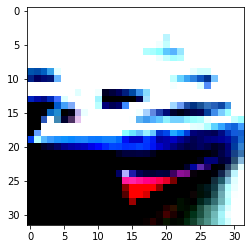

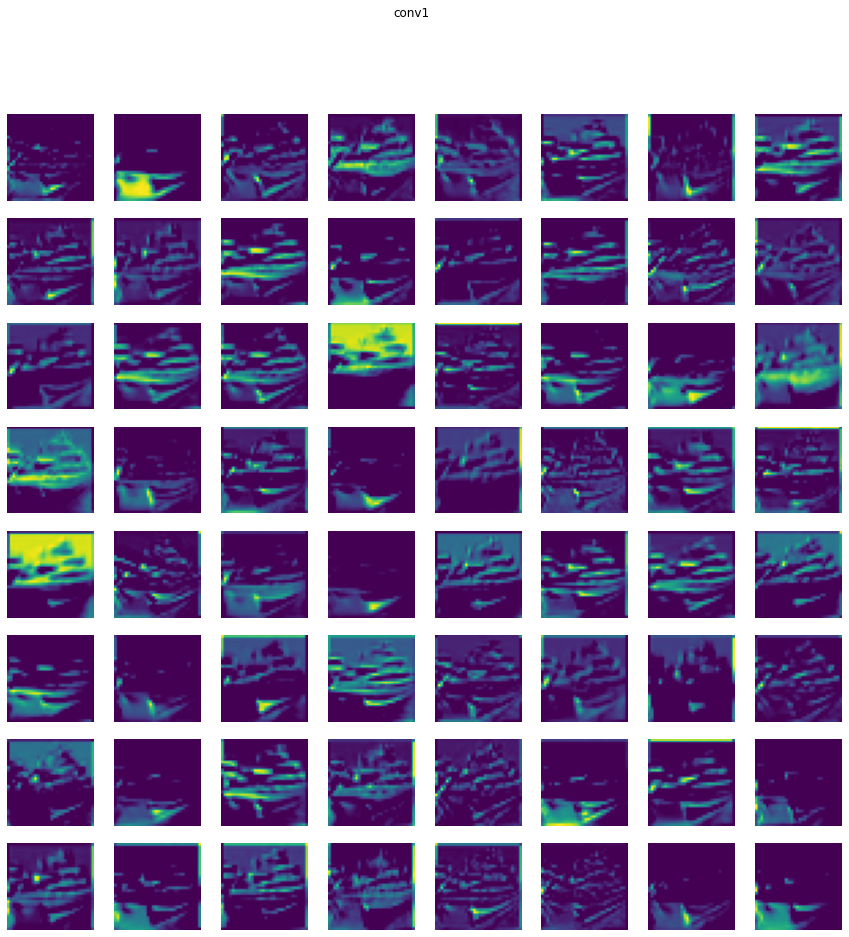

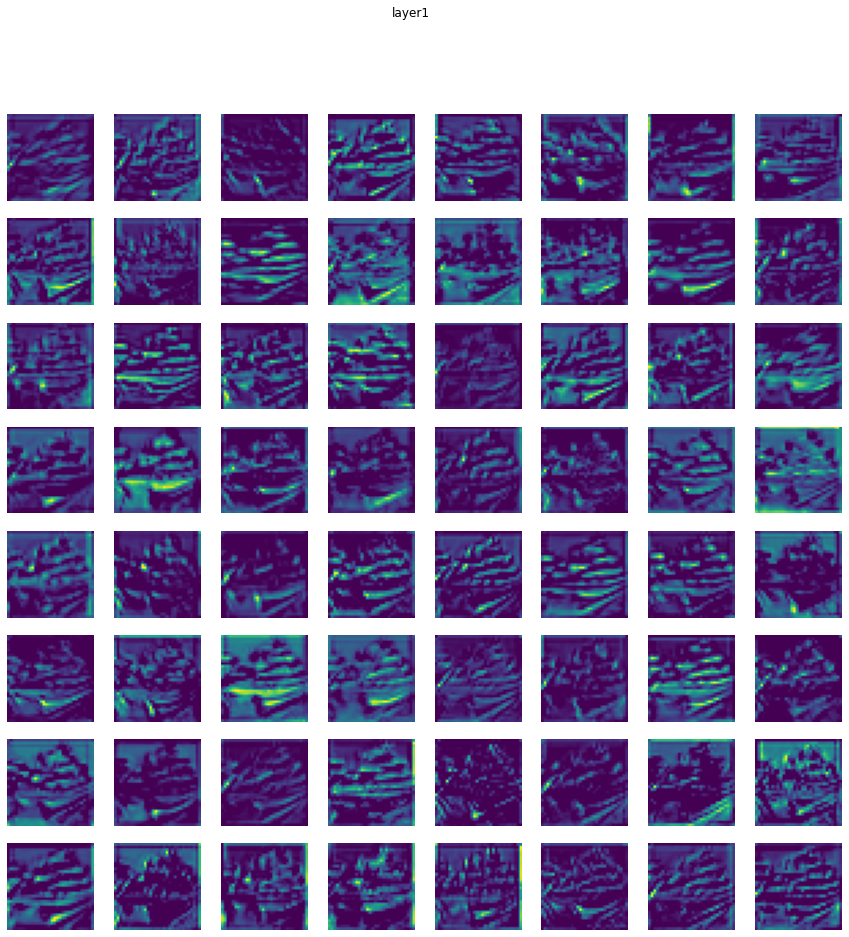

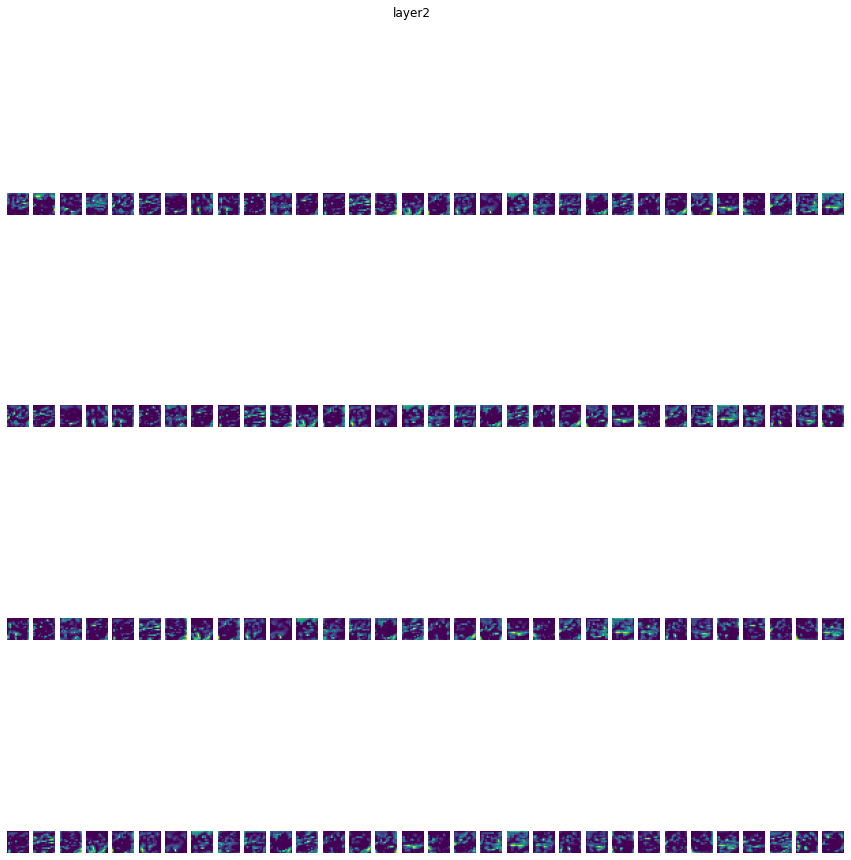

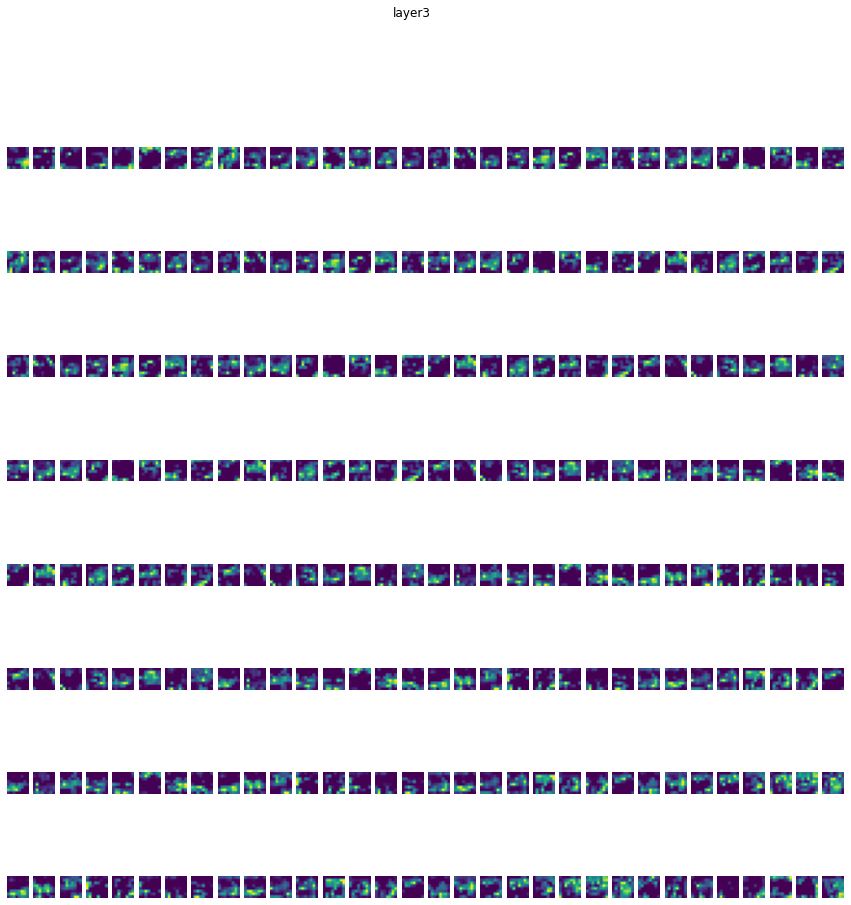

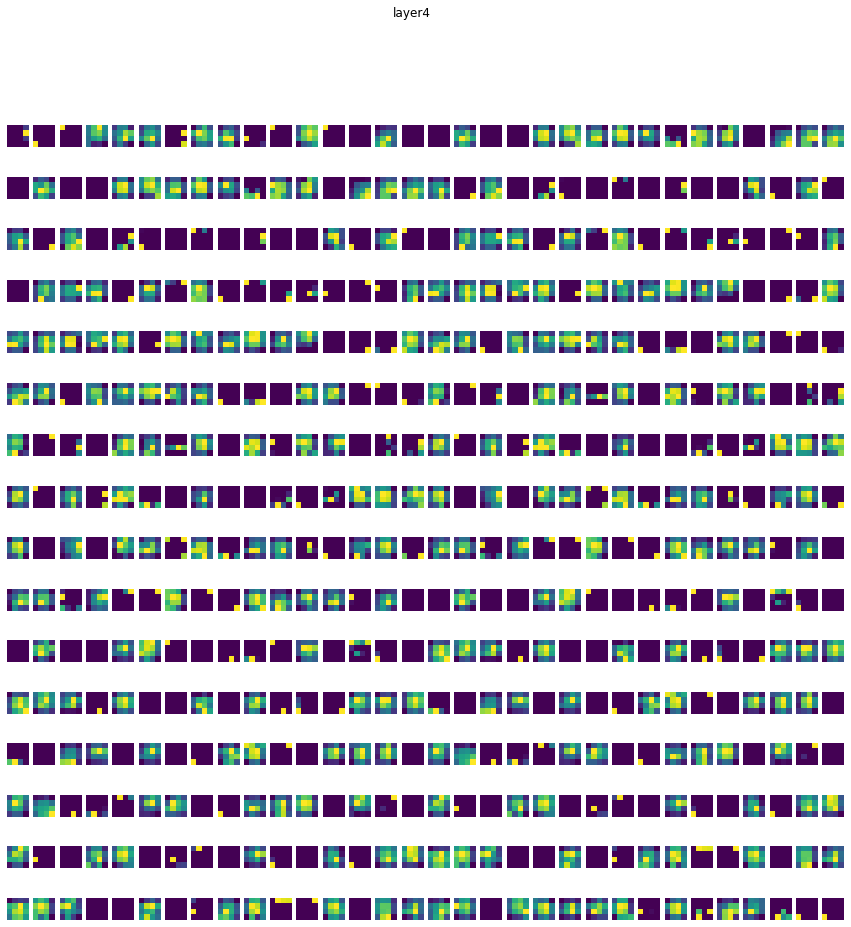

In [94]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
cifar10_test = dset.CIFAR10(root=data_dir, train=False, transform = transform, download=True) 
classes = cifar10_test.classes
data, label = cifar10_test[1]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)

data = data.squeeze()
print(data.shape)
data = data.cpu()
print(classes[label])
plt.imshow(data.permute(1, 2, 0)  )


for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols, figsize=(15,15))
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')